<a href="https://www.kaggle.com/code/azmiord/recommendation-systems-amazon-products?scriptVersionId=189325076" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv


# 1. Introduction

## 1.1 About the Data
Online E-commerce websites like Amazon and Flipkart use various recommendation models to provide personalized suggestions to users. Amazon employs item-to-item collaborative filtering, which can handle massive datasets and deliver high-quality recommendations in real time. This method matches each user's purchased and rated items to similar items, then combines those into a recommendation list tailored for the user. In this project, we aim to build a recommendation model for Amazon's electronics products.

The dataset used in this project is sourced from the Amazon Reviews data repository, specifically the Electronics dataset.

Source: [Amazon Reviews Data](http://jmcauley.ucsd.edu/data/amazon/)

## 1.2 Attribute Information
The dataset includes the following key attributes:

- userId: Unique identifier for each user.
- productId: Unique identifier for each product.
- Rating: The rating given by the user to the product.
- timestamp: The time when the rating was submitted.

## 1.3 Goals:
The primary goal of this project is to enhance the current manual recommendation process by leveraging machine learning techniques to predict and suggest products to users. Specifically, I aim to:

- Understand Customer Preferences: Analyze review data to gain insights into customer preferences and behavior.
- Build a Recommendation Model: Develop a recommendation system using collaborative filtering techniques, particularly Singular Value Decomposition (SVD).
- Evaluate Model Performance: Assess the accuracy and effectiveness of the recommendation system using appropriate metrics.
- Provide Actionable Recommendations: Generate product recommendations for users that can enhance their shopping experience and increase sales.

# 2. Introduction to Recommendation Systems
A recommendation system is an advanced machine learning application that suggests products, services, or content to users based on their preferences and past behavior.

## 2.1 Types of Recommendation System
There are several types of recommendation systems, including:

- Content-Based Filtering: Recommends items similar to those the user has liked in the past, based on item attributes.
- Collaborative Filtering: Recommends items based on the preferences of similar users or items. This method is particularly effective as it captures complex user-item interactions.
- User-Based Collaborative Filtering: Finds users similar to the target user and recommends items they liked.
- Item-Based Collaborative Filtering: Finds items similar to those the target user liked and recommends them.
- Hybrid Methods: Combine content-based and collaborative filtering to leverage the strengths of both approaches.

In this project, we focus on collaborative filtering using Singular Value Decomposition (SVD), a popular matrix factorization technique. SVD decomposes the user-item interaction matrix into latent factors representing user and item characteristics. This decomposition helps predict missing ratings and recommend products to users effectively.

## 2.2 Why SVD?
- Latent Factor Model: SVD captures latent factors, which are underlying features that influence user preferences and item characteristics.
- Scalability: SVD is computationally efficient and scalable, making it suitable for large datasets like the Amazon Product Reviews.
- Accuracy: SVD often provides high accuracy in predicting user preferences, making it a popular choice for collaborative filtering.

# 3. Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.model_selection import cross_validate
from surprise import KNNBasic

# 4. Data Understanding

In [3]:
# Load dataset
data = pd.read_csv("/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv",
                             names=['UserId', 'ProductId','Score','Time'])

In [4]:
# Display basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Score      float64
 3   Time       int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [5]:
# Display first few rows
data.head()

,UserId,ProductId,Score,Time
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
# Drop duplicates
data.drop_duplicates(subset=['UserId', 'ProductId'], keep='first', inplace=True)

# Handle missing values
data.dropna(subset=['UserId', 'ProductId', 'Score'], inplace=True)

In [7]:
#data shape after quick cleaning
data.shape

(7824482, 4)

# 5. Exploratory Data Analysis

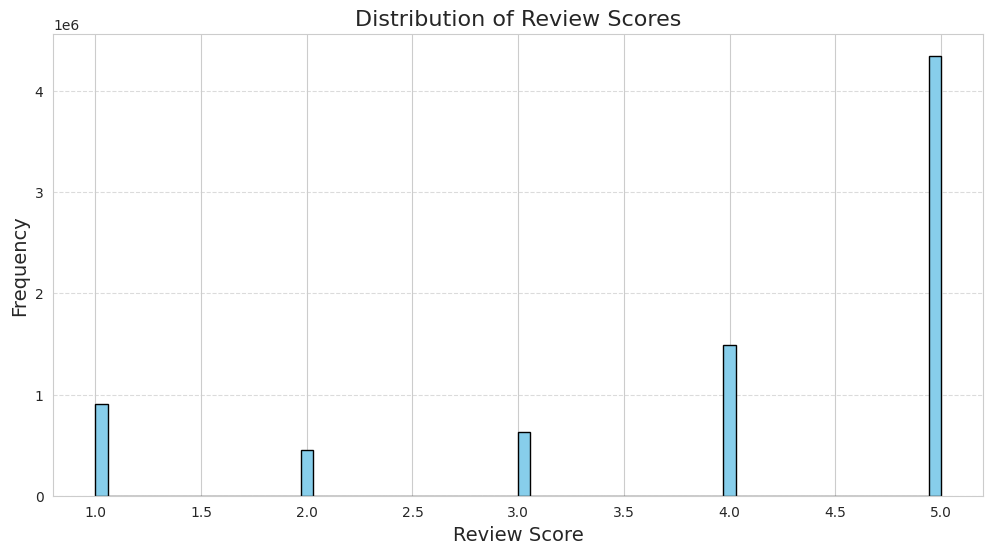

In [8]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Refined Histogram for Score Distribution
plt.figure(figsize=(12, 6))
plt.hist(data['Score'], bins=70, color='skyblue', edgecolor='black')

# Adding titles and labels
plt.title('Distribution of Review Scores', fontsize=16)
plt.xlabel('Review Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

- The distribution is indicating that most reviews are positive (scores 4.0 and 5.0).
- There is a noticeable drop-off in the frequency of reviews as the scores decrease from 5.0 to 1.0.
- The high frequency of 5.0 scores suggests that customers tend to give excellent reviews more often, potentially indicating high customer satisfaction or a bias towards positive reviews.

UserId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: count, dtype: int64


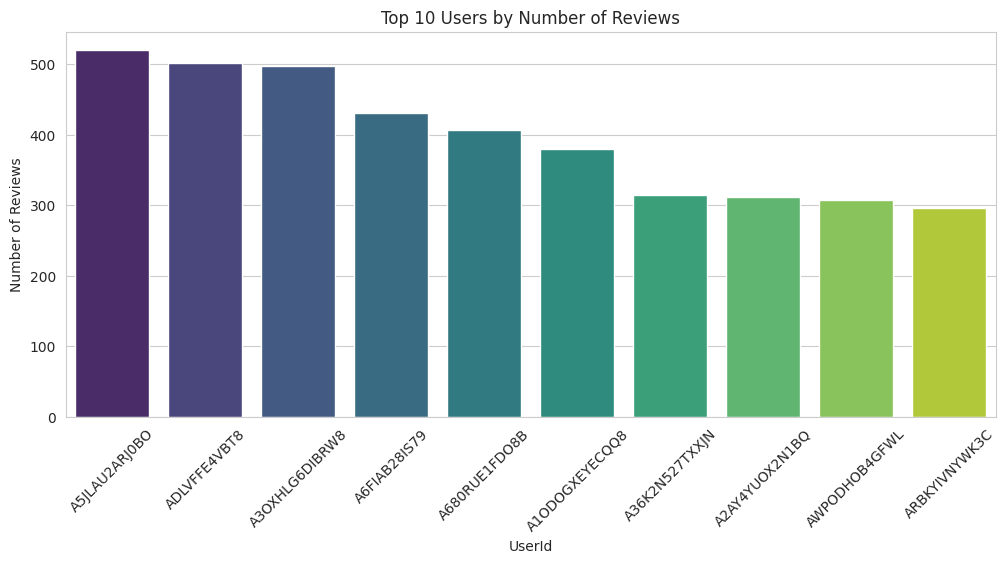

ProductId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
Name: count, dtype: int64


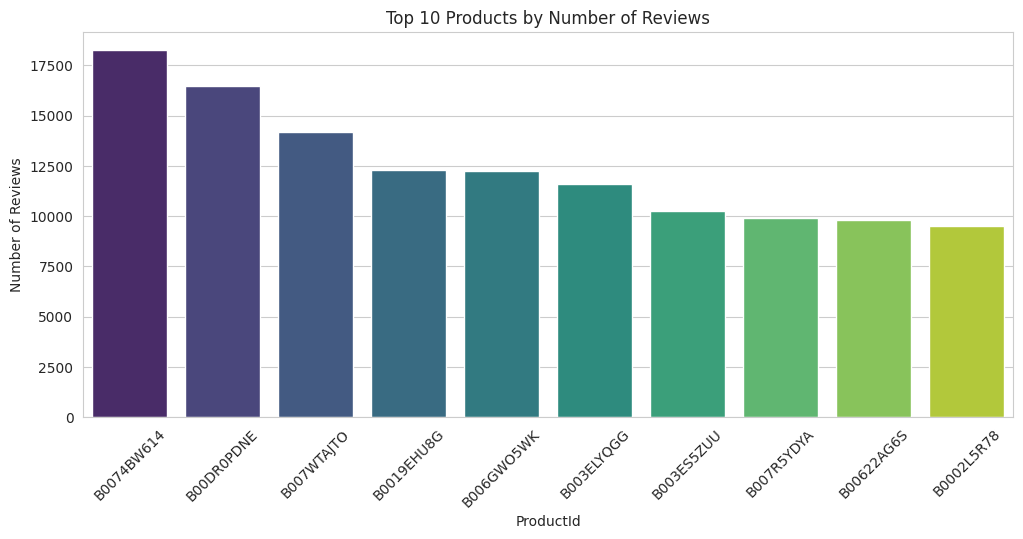

In [9]:
# Top 10 users with the most reviews
top_users = data['UserId'].value_counts().head(10)
print(top_users)

# Visualizing Top 10 users
plt.figure(figsize=(12, 5))
sns.barplot(x=top_users.index, y=top_users.values, palette='viridis')
plt.title('Top 10 Users by Number of Reviews')
plt.xlabel('UserId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

# Top 10 products with the most reviews
top_products = data['ProductId'].value_counts().head(10)
print(top_products)

# Visualizing Top 10 products
plt.figure(figsize=(12, 5))
sns.barplot(x=top_products.index, y=top_products.values, palette='viridis')
plt.title('Top 10 Products by Number of Reviews')
plt.xlabel('ProductId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

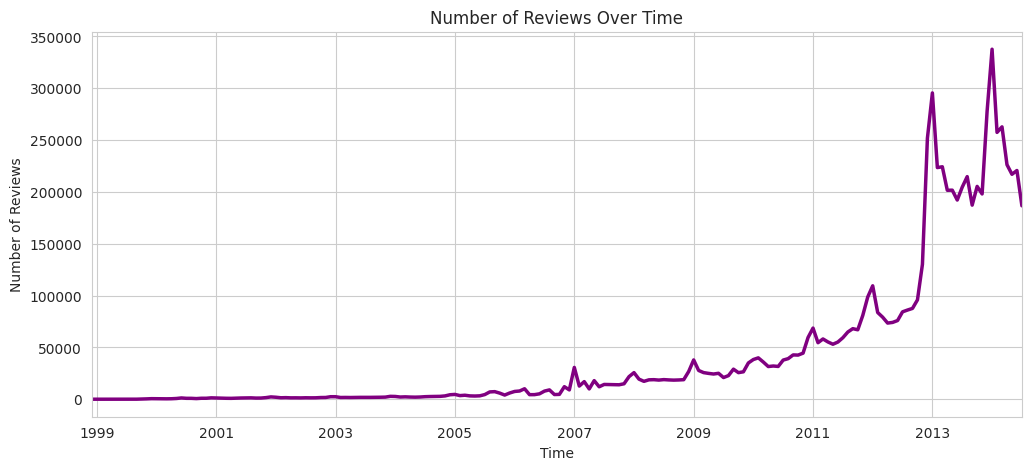

In [10]:
# Convert the Unix timestamp to a datetime object
data['Time'] = pd.to_datetime(data['Time'], unit='s')

# Number of reviews over time
plt.figure(figsize=(12, 5))
data.groupby(data['Time'].dt.to_period('M')).size().plot(kind='line', linewidth=2.5, color='purple')
plt.title('Number of Reviews Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Reviews')
plt.show()


- The significant growth in the number of reviews from 2011 onwards suggests an increase in user engagement and activity on the platform. This could be due to the increasing popularity of Amazon and the rise in online shopping during this period.
- The peaks and troughs in the later years could indicate seasonal variations or the impact of specific events/promotions that led to more reviews.

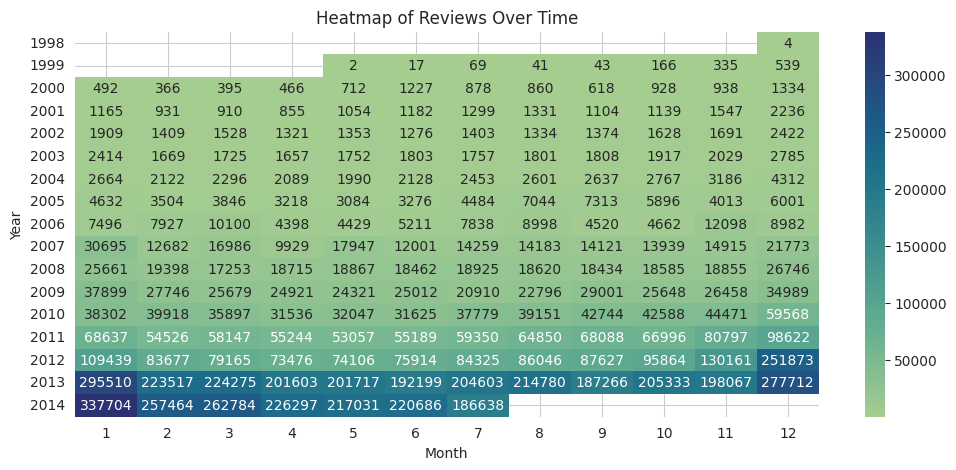

In [11]:
# Extract year and month from the Time column
data['Year'] = data['Time'].dt.year
data['Month'] = data['Time'].dt.month

# Pivot table to create a heatmap
heatmap_data = data.pivot_table(index='Year', columns='Month', values='Score', aggfunc='count')

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap='crest', annot=True, fmt='g')
plt.title('Heatmap of Reviews Over Time')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


- The substantial growth in the number of reviews over time reflects the increasing popularity of Amazon as an e-commerce platform.
- The spike in reviews during the holiday season (especially in December) highlights the impact of seasonal shopping trends on review activity.

# 6. Modelling

In [12]:
# Convert 'Score' to integer
data['Score'] = data['Score'].astype(int)

# Check for missing values
print(data.isnull().sum())

# Ensure UserId and ProductId are strings
data['UserId'] = data['UserId'].astype(str)
data['ProductId'] = data['ProductId'].astype(str)

UserId       0
ProductId    0
Score        0
Time         0
Year         0
Month        0
dtype: int64


In [13]:
# Load the data into Surprise format
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data[['UserId', 'ProductId', 'Score']], reader)

# Split the data into training and testing sets
trainset, testset = surprise_train_test_split(dataset, test_size=0.2)

# Initialize the SVD model
model = SVD()

# Train the model
model.fit(trainset)


In [14]:
# Test the model
predictions = model.test(testset)

# Evaluate the model
accuracy.rmse(predictions)

RMSE: 1.2950


1.2950137321622675

           UserId   ProductId  PredictedRating
0  A3OXHLG6DIBRW8  B000LQEUJ8         4.488475
1  A3OXHLG6DIBRW8  B001EO5Q64         4.488475
2  A3OXHLG6DIBRW8  B000LQUP6U         4.488475
3  A3OXHLG6DIBRW8  B000M2GYF6         4.908664
4  A3OXHLG6DIBRW8  B000N99BBC         4.926161


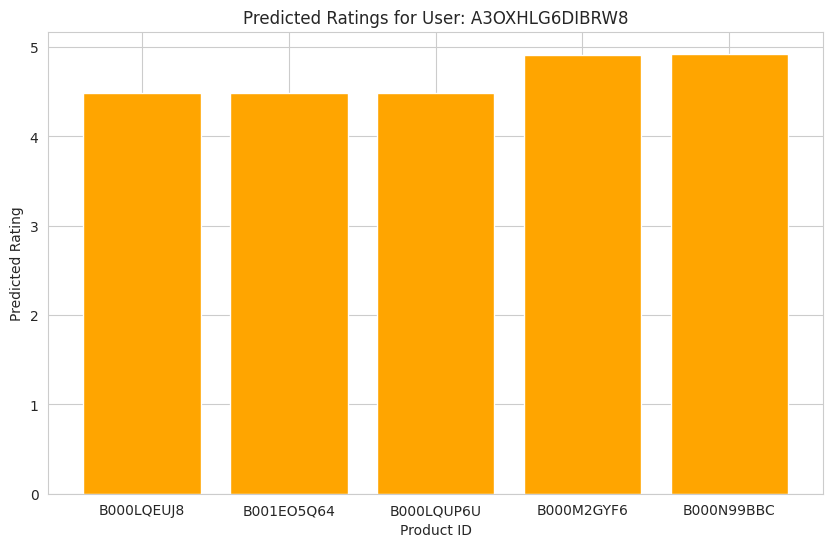

In [15]:
# Example: Predict ratings for a specific user and a set of products
user_id = 'A3OXHLG6DIBRW8'
product_ids = ['B000LQEUJ8', 'B001EO5Q64', 'B000LQUP6U', 'B000M2GYF6', 'B000N99BBC']

# Get predictions for the user
predicted_ratings = []
for product_id in product_ids:
    pred = model.predict(user_id, product_id)
    predicted_ratings.append((user_id, product_id, pred.est))

# Convert to DataFrame for better visualization
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=['UserId', 'ProductId', 'PredictedRating'])

# Display the predicted ratings
print(predicted_ratings_df)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.bar(predicted_ratings_df['ProductId'], predicted_ratings_df['PredictedRating'], color='orange')
plt.xlabel('Product ID')
plt.ylabel('Predicted Rating')
plt.title('Predicted Ratings for User: {}'.format(user_id))
plt.show()


           UserId   ProductId  PredictedRating
0  A2WNBOD3WNDNKT  B000LQEUJ8         4.012431
1  A2WNBOD3WNDNKT  B001EO5Q64         4.012431
2  A2WNBOD3WNDNKT  0132793040         4.012431
3  A2WNBOD3WNDNKT  B000M2GYF6         4.388406
4  A2WNBOD3WNDNKT  B000N99BBC         4.572833


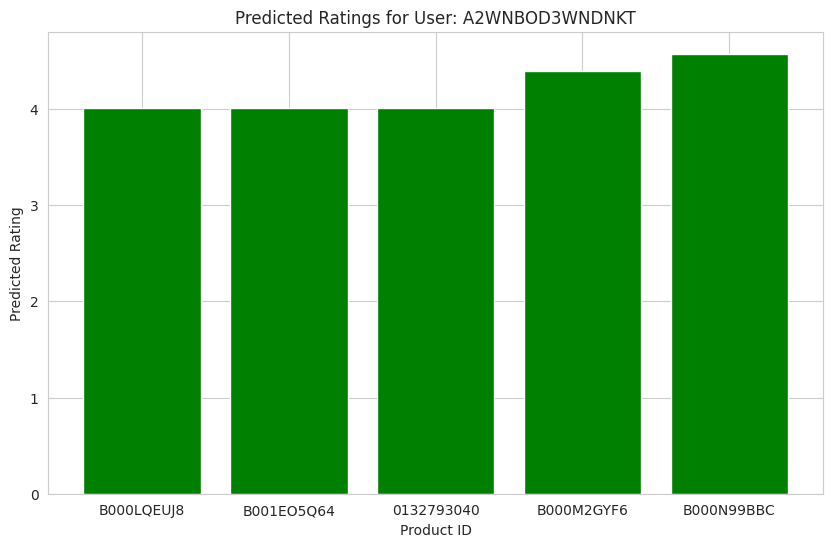

In [16]:
# Example: Predict ratings for a specific user and a set of products
user_id = 'A2WNBOD3WNDNKT'
product_ids = ['B000LQEUJ8', 'B001EO5Q64', '0132793040', 'B000M2GYF6', 'B000N99BBC']

# Get predictions for the user
predicted_ratings = []
for product_id in product_ids:
    pred = model.predict(user_id, product_id)
    predicted_ratings.append((user_id, product_id, pred.est))

# Convert to DataFrame for better visualization
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=['UserId', 'ProductId', 'PredictedRating'])

# Display the predicted ratings
print(predicted_ratings_df)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.bar(predicted_ratings_df['ProductId'], predicted_ratings_df['PredictedRating'], color='green')
plt.xlabel('Product ID')
plt.ylabel('Predicted Rating')
plt.title('Predicted Ratings for User: {}'.format(user_id))
plt.show()


# 7. Conclusion
- **Objective Achieved**: The main objective of this project was to develop a recommendation system using machine learning techniques to predict user ratings for products. This goal was successfully achieved by employing the SVD (Singular Value Decomposition) algorithm.
- **Practical Application**: The recommendation system can be utilized by e-commerce platforms to provide personalized product recommendations to users, enhancing user experience and potentially increasing sales.

# 8. Further Improvements
- **Model Enhancement**: Explore and implement other advanced recommendation algorithms such as Matrix Factorization, Deep Learning models, or hybrid approaches to further improve prediction accuracy.
- **Data Augmentation**: Incorporate additional features such as user demographics, product descriptions, and contextual data to enhance the model's ability to make more personalized recommendations.
- **Cold Start Problem**: Address the cold start problem by implementing techniques such as content-based filtering or using external data sources to provide recommendations for new users and products.
- **Real-Time Recommendations**: Develop a real-time recommendation engine that can update predictions based on user interactions and recent data, ensuring up-to-date and relevant recommendations.